Import library: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CPU or GPU:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


Load Cifar10 dataset :

In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize( 
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) 
    )
])
train_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Validataion data: 

In [ ]:
torch.manual_seed(43)
val_size = int(len(train_dataset) * 0.10)
train_size = len(train_dataset) - val_size



train_dataset, validation_dataset = random_split(train_dataset, [train_size, val_size])


len(train_dataset), len(validation_dataset)


(45000, 5000)

dataloader : 

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Defense:

Fit function : 

In [ ]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss



Defensive distillation:

In [ ]:



def defense(device,train_loader,val_loader,epochs,Temp,lr):

   #  teacher model : 
  modelF = models.vgg16(pretrained = True)
  input_lastLayer = modelF.classifier[6].in_features
  modelF.classifier[6] = nn.Linear(input_lastLayer,10)
  modelF = modelF.to(device)

  optimizerF = torch.optim.Adam(modelF.parameters(),lr=lr, betas=(0.9, 0.999))
  schedulerF = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

# student model : 

  modelF1 = models.vgg16(pretrained = True)
  input_lastLayer = modelF1.classifier[6].in_features
  modelF1.classifier[6] = nn.Linear(input_lastLayer,10)
  modelF1 = modelF1.to(device)  

  optimizerF1 = torch.optim.Adam(modelF1.parameters(),lr=lr, betas=(0.9, 0.999))
  schedulerF1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

# set criterion : 
  # criterion = nn.NLLLoss()
  criterion = nn.CrossEntropyLoss()


# fit teacher model: 
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)

  torch.save(modelF.state_dict(), '/content/drive/MyDrive/AD_CA4/Vgg/Pretrained/teacher_model.pt')

# validation and train loss plot (teacher model )


  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()



  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

# fit student model : 

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)


# validation and train loss plot (student model )
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

# save student model : 

  torch.save(modelF1.state_dict(), '/content/drive/MyDrive/AD_CA4/Vgg/Pretrained/student_model.pt')






training the student and teacher model : 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Fitting the model...
Epoch: 1 Loss: 1.610011075351284 Val_Loss: 1.238627066278154
Epoch: 2 Loss: 1.105661686464837 Val_Loss: 1.1530816239915835
Epoch: 3 Loss: 0.8933957032515126 Val_Loss: 0.9134253143884574


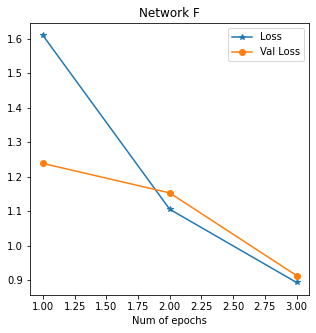

Fitting the model...
Epoch: 1 Loss: 1.7639008126702813 Val_Loss: 1.4753169109866877
Epoch: 2 Loss: 1.2258555957333959 Val_Loss: 1.1205351865215667
Epoch: 3 Loss: 1.0388974496974281 Val_Loss: 1.020423567219145


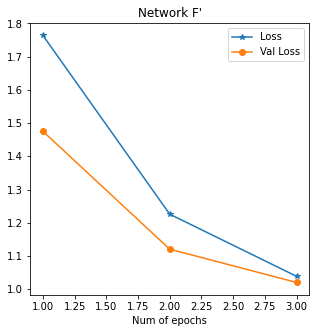

In [ ]:
Temp=100
epochs=3

num_epochs = 3
learning_rate = 0.001


classes = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')



defense(device,train_loader,validation_loader,epochs,Temp,learning_rate)


FGSM attack  : 

Load model : 

In [ ]:
# model = models.vgg16(pretrained = True)
# input_lastLayer = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(input_lastLayer,10)
# model = model.to(device)

# model.load_state_dict(torch.load('/content/drive/MyDrive/AD_CA4/Vgg/Pretrained/distil_model.pt'))
# model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
## Standard libraries
import os
import json
import math
import time
import numpy as np 
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Global seed set to 42


Using device cpu


In [ ]:
# epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model_ = '/content/drive/MyDrive/AD_CA4/Vgg/Pretrained/student_model.pt'
use_cuda=True


# Initialize the network
pretrained_model = models.vgg16(pretrained = True)
input_lastLayer = pretrained_model.classifier[6].in_features
pretrained_model.classifier[6] = nn.Linear(input_lastLayer,10)
pretrained_model = pretrained_model.to(device)

# Load the pretrained model
pretrained_model.load_state_dict(torch.load(pretrained_model_, map_location='cpu'))


# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels) 
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [ ]:


_ = eval_model(test_loader)

Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 90.00%
Top-5 error: 50.00%


In [ ]:
NORM_MEAN = np.array([0.4914, 0.4822, 0.4465])
NORM_STD = np.array([0.2023, 0.1994, 0.2010])



In [ ]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1 
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    
    plt.show()
    plt.close()

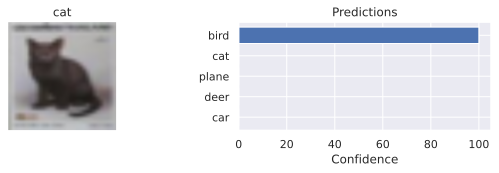

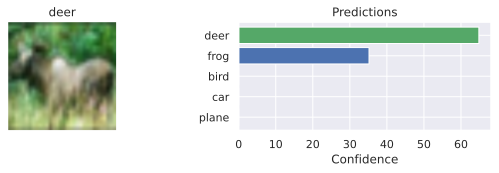

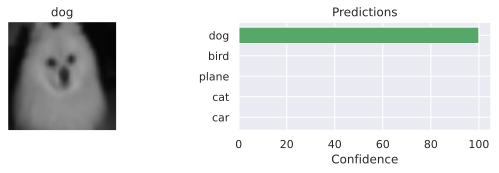

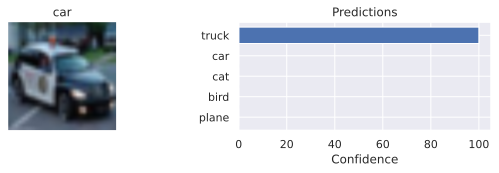

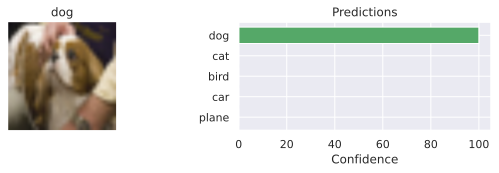

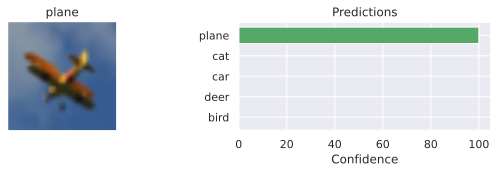

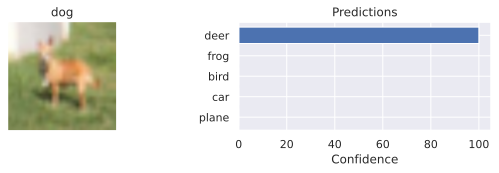

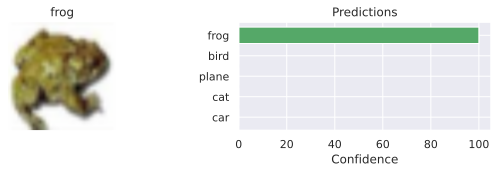

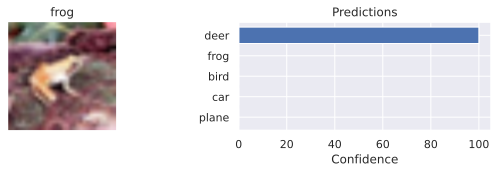

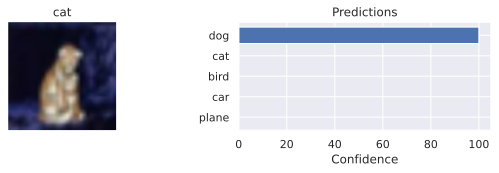

In [ ]:
exmp_batch, label_batch = next(iter(test_loader))
label_names = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(10):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

In [ ]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

In [ ]:
exmp_batch, label_batch = next(iter(test_loader))
label_names = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')


def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    grad = inp_imgs.grad.to(imgs.device)

    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


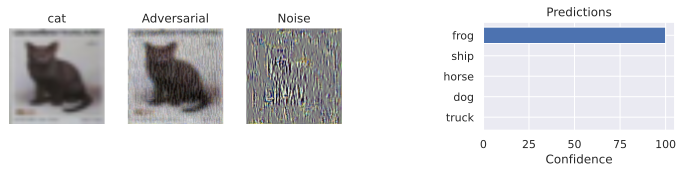

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


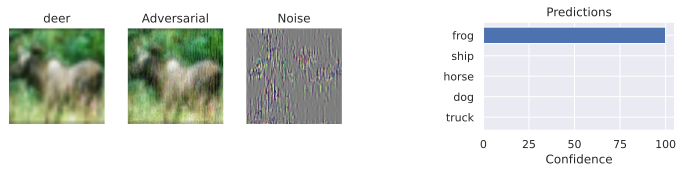

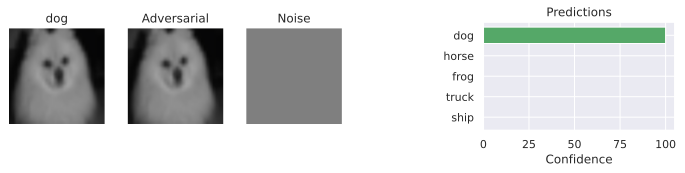

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


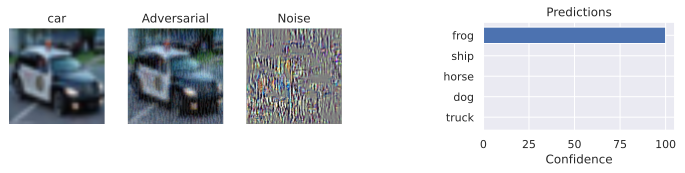

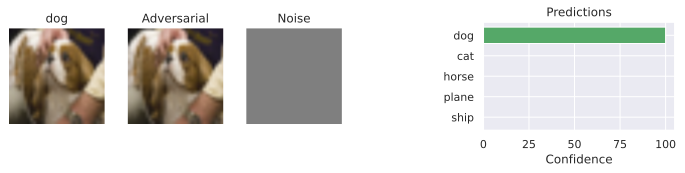

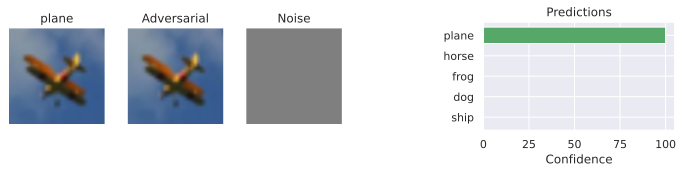

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


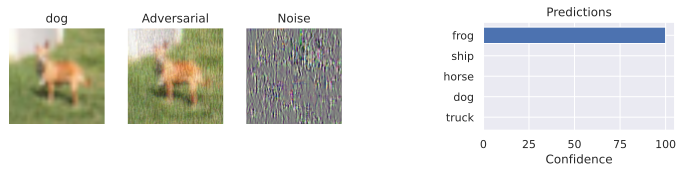

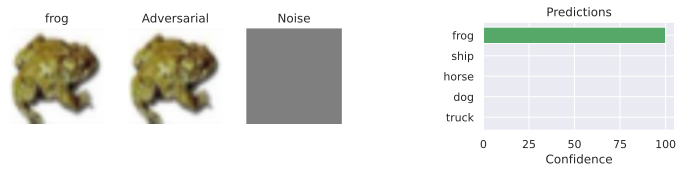

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


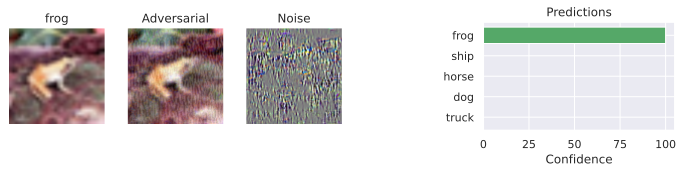

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


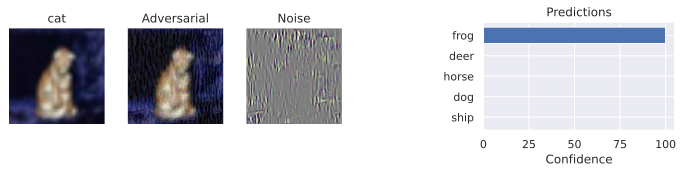

In [ ]:
# adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.5)
# with torch.no_grad():
#     adv_preds = pretrained_model(adv_imgs.to(device))
    
for i in range(10):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

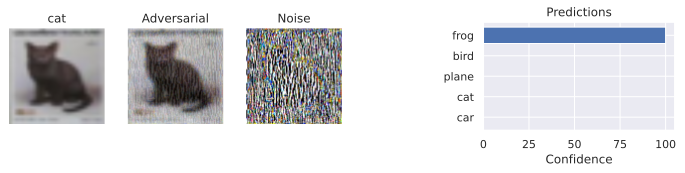

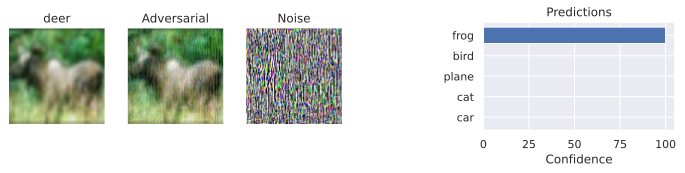

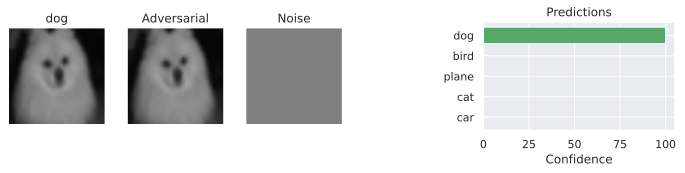

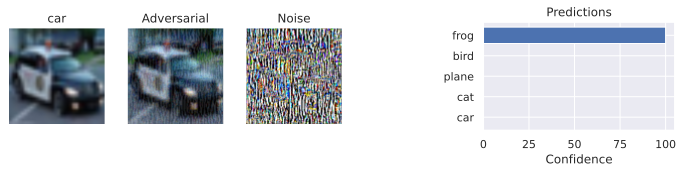

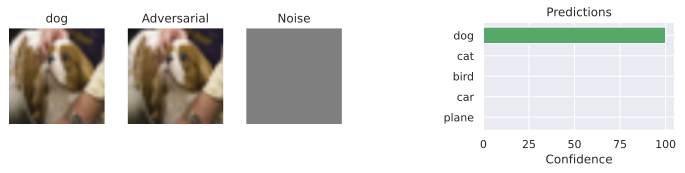

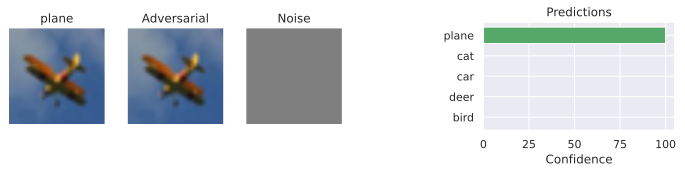

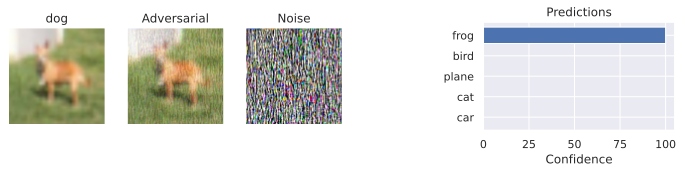

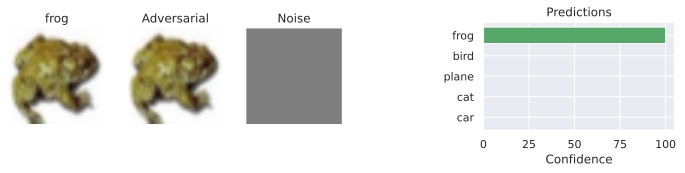

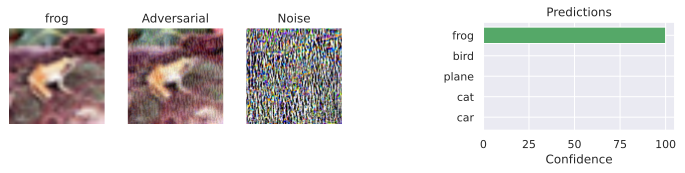

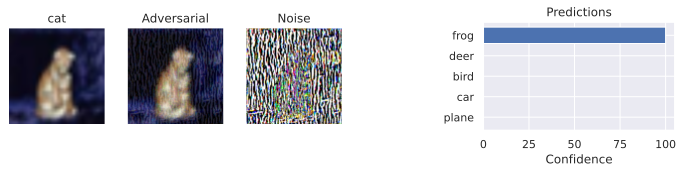

In [ ]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.5)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))
    
for i in range(10):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

In [ ]:
# exmp_batch, label_batch = next(iter(test_loader))
accuracy = []
epsilon = [0,0.1,0.2,0.3,0.4,0.5]

for eps in epsilon:
  number_corrects = 0
  number_samples = 0
  for exmp_batch, label_batch in test_loader: 
    adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=eps)
    with torch.no_grad():
      adv_preds = pretrained_model(adv_imgs.to(device))
      labels_predicted = adv_preds.argmax(axis = 1)
      label_batch  = label_batch.to(device)
      number_corrects += (labels_predicted==label_batch).sum().item()
      number_samples += label_batch.size(0)
  accuracy.append(number_corrects/number_samples)
      
print(accuracy)


[0.6584, 0.5423, 0.5415, 0.5413, 0.5406, 0.5406]


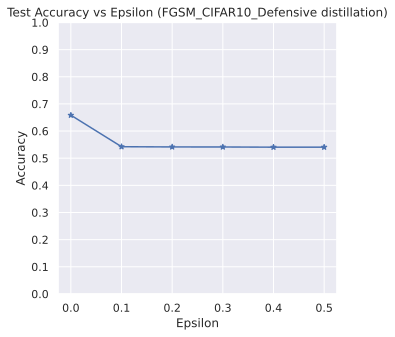

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilon, accuracy, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.title("Test Accuracy vs Epsilon (FGSM_CIFAR10_Defensive distillation)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()